## Proposing an effective Backtesting strategy using Bayesian Modeling 

### By: Serena Liu, Lin Ye and Akshat Mittal 

## 1 Introduction

Backtesting is a key component of effective trading system development. It is accomplished by reconstructing, with historical data, trades that would have occurred in the past using rules defined by a given strategy. The result offers statistics to gauge the effectiveness of the strategy. 




In this project, our team proposes a novel way to generate a backtesting strategy, where we make use of Bayesian Modeling to predict quarterly returns and industry groups and building our strategy based on them. Bayesian modelling is particularly helpful in the application of finance where data set is smaller and higher noise. As an extension to industry wide practice of frequentist models,  our approach incorporates probablistic interpretation to return predictions. In addition, we extend the probabilistic intepretation to clustering industries as well. We constructed industry neutral backtests with GICs industry code and our own version of industries from GMM model.   


Global Industry Classification Standard (GICS) is a framework which dilineates companies into 11 sectors. The framework further classifies companies into 24 industry groups, 68 industries, and 157 subindustries, but we limit our focus to the sector level classification.

Two things stand out for this classification:
- This classfication of companies is based not on any financial factors, but on the product or service they provide
- This is a hard classification i.e. at a certain time, companies usually have a single GICS code associated with them

In this work, we try to come up with a soft classification of companies into sectors using their values of their financial fundamental indicators using a Bayesian Gaussian Mixture Model where each component of the mixture would.

Using the posterior associations of each component for each data point, we supplant the indicator GICS in our two predictive models: Bayesian Linear Regression and Bayesian Neural Network and do a comparative analysis of our backtest for both types of models - the predictive models having GIC indicators with the predictive models having soft classifications

## 2 Data

We use the company fundamentals data for 500 companies over 10 years from 2009 to 2019 at a quarterly frequency along with the close price (which is eventually used by converting them to return values). This data was downloaded from [SimFin](https://simfin.com/), which makes fundamentals financial data available for free.

In order to avoid problems related to multicollinearity as well as to keep in check the fact that we only use meaningful features, we manually removed one feature per pair where the pair had a correlation of 0.7 or more. This left us with 19 predictors. As a consequence of the frequency of the data and what we plan to predict, we performed following steps of preprocessing:

1. removed the rows with missing features
2. realigned the dates to month-end dates
3. normalized the features, z-scored each features cross sectionally 

Our final list of fundamentals, which will eventually serve as predictors of the return, are shown below in the correlation table

In [1]:
import warnings
warnings.filterwarnings('ignore')
from preprocess import preprocess
data, y_tr, X_ts, y_ts = preprocess(ret_type='df')

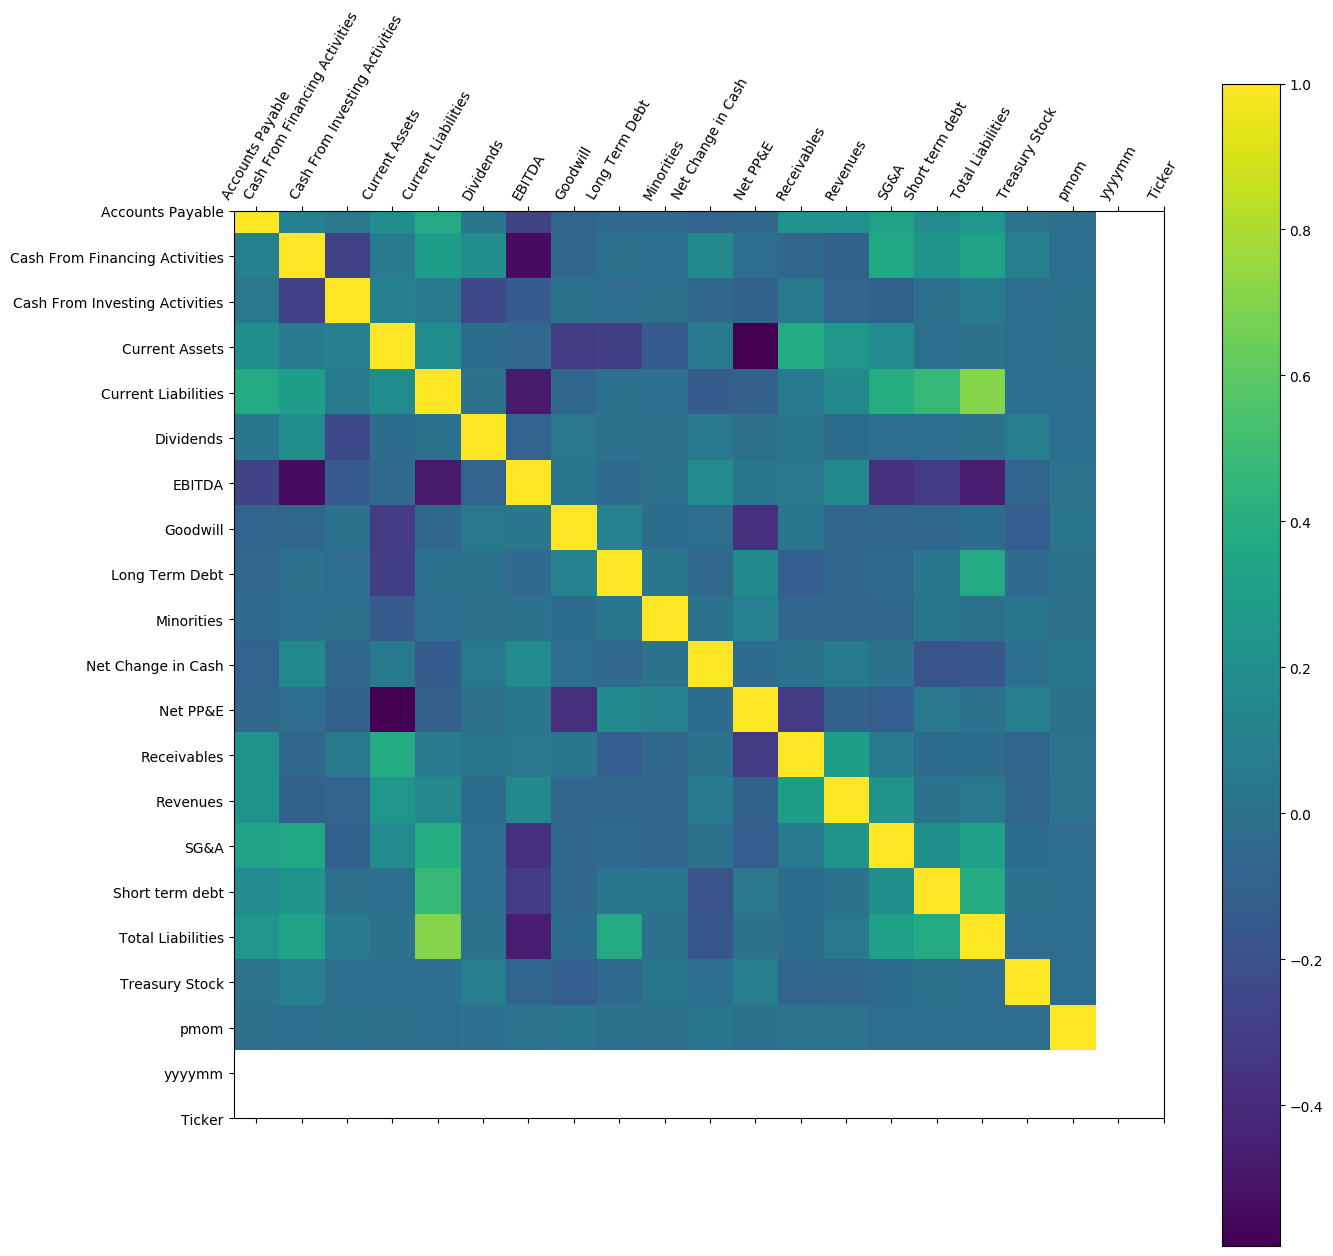

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15), dpi=100)
plt.matshow(data.corr(), fignum=1)
plt.xticks(range(len(data.columns)), data.columns, rotation=60)
plt.yticks(range(len(data.columns)), data.columns)
plt.colorbar()
plt.show()

## 3 Sector Identification using Bayesian GMM

### 3.1 Background

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. What makes it Bayesian is the fact that we define appropriate priors on mixture weights, and the means and standard deviations of the Gaussians.

### 3.2 Model

We assume an relatively intuitive data generating process for the fundamentals of a stock. According to our model, the fundamentals of a stock are a random draw from a Gaussian Mixture of 11 components, where each component represents a 'pseudo-sector', making the dimension of each component of the mixture equal to the dimension of our dataset (-1 for quarterly returns). For each datapoint in our data, we have:

<h2><center>$\pi \sim Dirichlet(\alpha)$</center></h2>

**For each component** $k$ :

<h2><center>$\mu_{k} \sim N(\mu_{0k}, \sigma^{2}_{0k}I)$</center></h2>
<h2><center>$\sigma_{k} \sim LogNormal(\mu_{1k}, \sigma^{2}_{1k})$</center></h2>

**For each datapoint** $i$:

<h2><center>$c_{i} \overset{iid}{\sim} Discrete(\pi)$</center></h2>
<h2><center>$x_{i} \sim N(\mu_{c_{i}}, \sigma^{2}_{c_{i}} I)$</center></h2>

Using the posterior distributions for $\pi$ and the Bayes Estimates for the component means and standard deviations, we calculate each new (from the test set) datapoint's pseudo-sector using the vector obtained from $p(c_{i}=k|x_{new})$, which is better known as the Posterior Responsibilities, and essentially simplifies to the following using Bayes Rule:

<h2><center>$p(c_{i}=k|x_{new}) = \frac{p(c_{i}=k) p(x_{new}|c_{i}=k)}{\sum_{i=1}^{k}p(c_{i}=k) p(x_{new}|c_{i}=k)}$</center></h2>

<h2><center>$\implies  p(c_{i}=k|x_{new}) = \frac{w^{posterior} p(x_{new}|\mu_{k}^{posterior}, \sigma^{2posterior}_{k})}{\sum_{i=1}^{k}w^{posterior} p(x_{new}|\mu_{k}^{posterior}, \sigma^{2posterior}_{k})}$</center></h2>

It is these responsibilities which are used during the Backtesting as a proxy for GICS codes.

### 3.3 Inference

Defining a manual guide in Pyro, we use Stochastic Variational Inference to learn our model. We also tried MCMC for a relatively small sample of the data, but the samples generated from it had suspiciously low variance, which is one of the reasons we discarded it for SVI along with the immense computational overhead for running MCMC for 19 dimensional models for a moderately sized dataset.

running for n_comp = 11
Initializing object for inference method svi
Size of train tensor: torch.Size([20412, 19])
Size of test tensor: torch.Size([10280, 19])
Determining best seed for initialization
Best seed determined after 100 random initializations:
seed = 37, initial_loss = 609958.375
Running SVI iterations

 Losses stored in variable loss
Posterior samples stored in variable samples with shape 3
Number of nulls in resps: 704
{'num_samples': 20412, 'num_iterations': 1000, 'exec_time': 395.05692744255066}


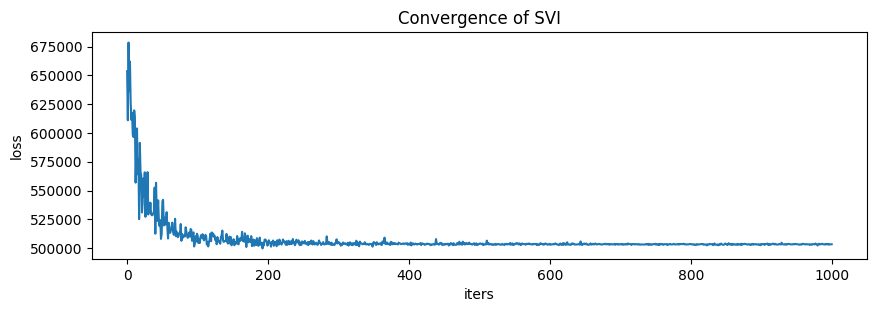

In [3]:
from run_gmm import run_gmm
resp, null_indexes = run_gmm(n_comp=11, n_itr=1000)

## 4  Return Prediction

### 4.1 Bayesian Linear Regression

#### 4.1.1 Model

We constructed a Bayesian linear regression model as a baseline model to evaluate performance. The model takes in the 19 features as mentioned above.The predicted variable y is assumed to be drawn from a normal distribution:

<h2><center>$ y \sim N(\beta^{T}X,\sigma^2 I)$</center></h2>

The model parameters $\beta_i$s  are assumed to come from normal distributions. For each $\beta_i $, the prior is drawn from: $ \beta_i \sim N(0,1)$ (assuming all betas to be indepedent of each other) 

$\sigma$ is drawn from a lognormal distribution $ \sigma \sim$ LogNormal(0,5) . 

#### 4.1.2 Inference

We make inference via SVI.

Loading data
Running SVI for 10000 iterations
Plotting losses


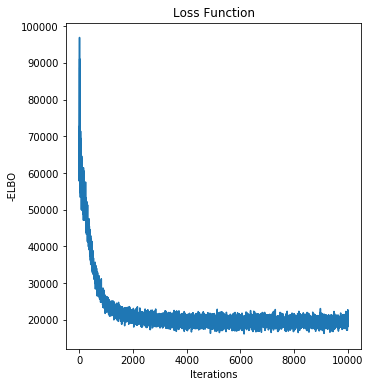

Getting posterior estimates
Getting predictions


In [4]:
from bayes_lin_regr import *
import warnings
warnings.filterwarnings('ignore')
preds = main(itr=10000)

### 4.2 Bayesian Neural Network

A Bayesian neural network is a neural network with a prior distribution on its weights

#### 4.2.1 Model

Consider a data set ${(x_n, y_n)}$,  where each data point comprises of features $x_n \in R^D$ and output $y_n \in R$. Define the likelihood for each data point as $P(y_n|w, x_n, \sigma^2) = Normal (y_n|NN(x_n;w), \sigma^2)$, where NN is a neural network whose weights and biases from the latent variables $w$.


Assume $\sigma = LogNormal(\mu,0.05)$.

Define the prior on the weights and biases $w$ to be the standard normal.

$p(w) =$ Normal $(w|0,I)$.

#### 4.2.2 Inference

## 6 Backtesting Strategy

Backtesting allows us to simulate our trading strategy using historical returns data. By buying stocks with high return prediction and selling stocks with low return prediction at every quarter end, we generated a wealth curve to see how will 1$ do if invested in our strategies.

We formulated four backtesting strategies. 
<br>
Baseline case: Bayesian linear regression with GICs Industry grouping<br>
Version 1: Bayesian linear regression with Industry grouping from GMM model<br>
Version 2: Bayesian neural network model  with GICs Industry grouping

Here are our backtest results:

### 6.1 Bayesian linear regression with Industry grouping from GMM model

(10280, 21)
(10280, 4)
alpha weighted, market neutral


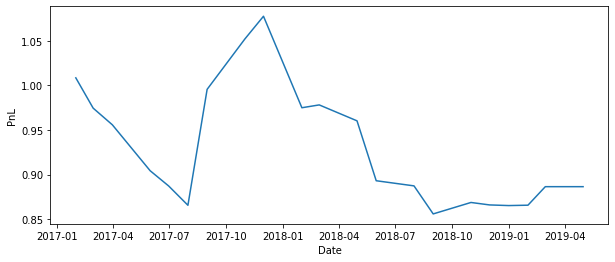

sharpe ratio -0.1936, annual return -0.0227, mdd 0.2218

equal weighted, market neutral


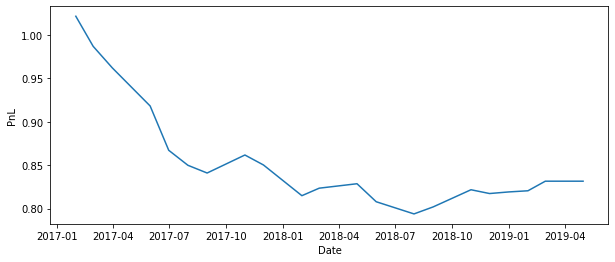

sharpe ratio -0.7426, annual return -0.0345, mdd 0.2279

alpha weighted, industry neutral


ValueError: Length mismatch: Expected axis has 8906 elements, new values have 10280 elements

In [49]:
df_back = get_data()
final_df_0 = merge_with_tix_gics(df_back, preds, X_ts)
main(final_df_0)

### 6.2 Bayesian linear regression with Industry grouping from GMM model

alpha weighted, market neutral


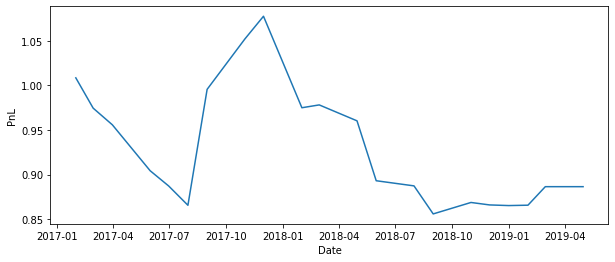

sharpe ratio -0.1936, annual return -0.0227, mdd 0.2218

equal weighted, market neutral


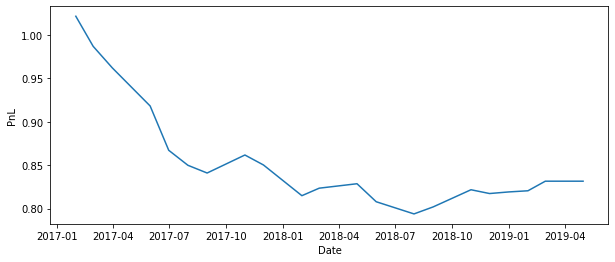

sharpe ratio -0.7426, annual return -0.0345, mdd 0.2279

alpha weighted, industry neutral


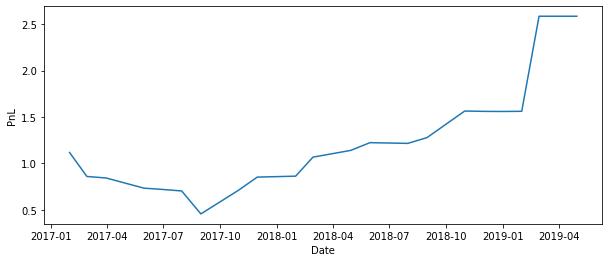

sharpe ratio 0.6128, annual return 0.1982, mdd 0.6613

equal weighted, industry neutral


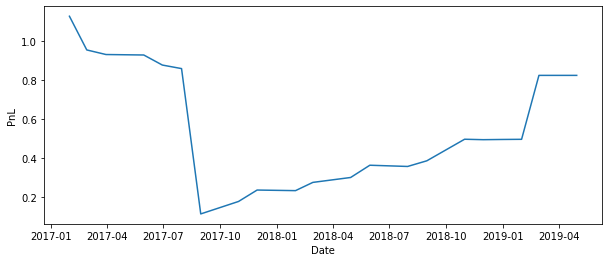

sharpe ratio 0.4561, annual return -0.0362, mdd 1.0148



In [6]:
from backtester import *
final_df = merge_with_tix(resp, preds, X_ts)
main(final_df)

### 6.3 Bayesian Neural Network with Industry grouping from GICS model

Plotting losses


/Users/linye/Columbia/Courses/2019Fall/COMS6998_Machine_Learning_with_Probabilistic_Programming/ML-with-Prob-Prog-Final-Project/Bayesian_Neural_Network/backtest_helper.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['alpha'] = self.model.predict(X_tensor, n_samples=100)
/Users/linye/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  wa

alpha weighted, market neutral


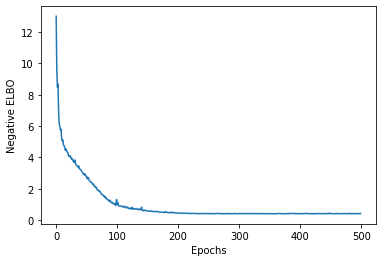

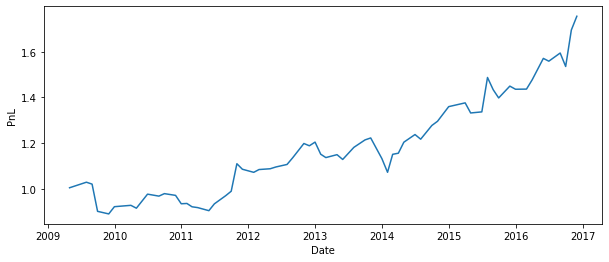

sharpe ratio 0.4809, annual return 0.0358, mdd 0.1502

equal weighted, market neutral


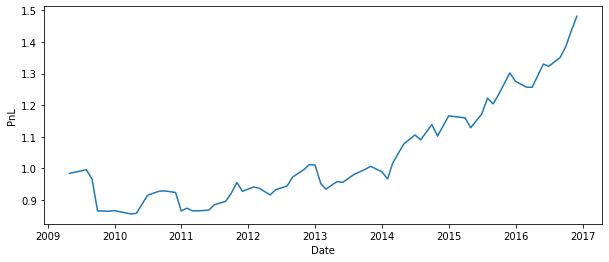

sharpe ratio 0.4385, annual return 0.0249, mdd 0.1399

alpha weighted, industry neutral


/Users/linye/Columbia/Courses/2019Fall/COMS6998_Machine_Learning_with_Probabilistic_Programming/ML-with-Prob-Prog-Final-Project/Bayesian_Neural_Network/backtest_helper.py:70: RuntimeWarning: invalid value encountered in double_scalars
  annual_return = np.prod(1+self.port_rtns)**(4/len(self.port_rtns)) - 1


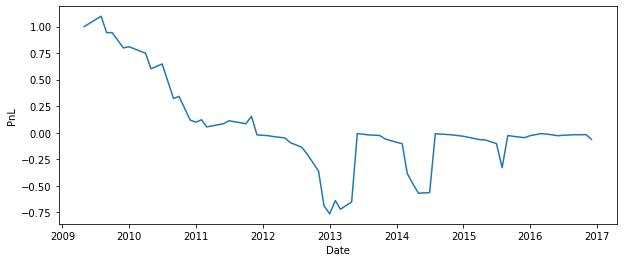

sharpe ratio 0.6626, annual return nan, mdd 1.8634

equal weighted, industry neutral


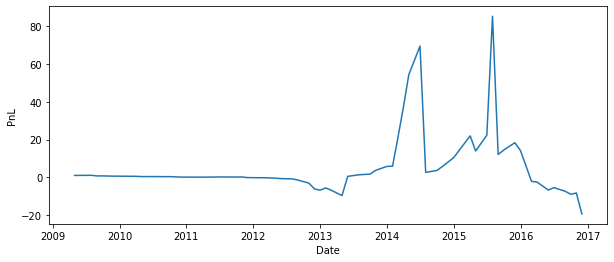

sharpe ratio 0.6936, annual return nan, mdd 104.6680

alpha weighted, market neutral


/Users/linye/Columbia/Courses/2019Fall/COMS6998_Machine_Learning_with_Probabilistic_Programming/ML-with-Prob-Prog-Final-Project/Bayesian_Neural_Network/backtest_helper.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['alpha'] = self.model.predict(X_tensor, n_samples=100)


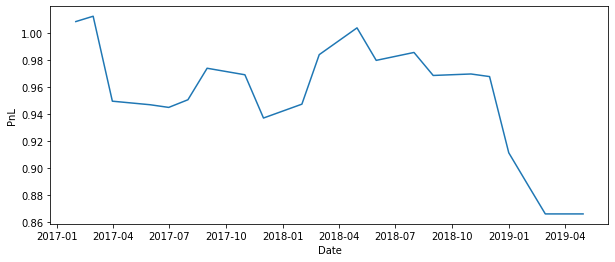

sharpe ratio -0.5354, annual return -0.0270, mdd 0.1466

equal weighted, market neutral


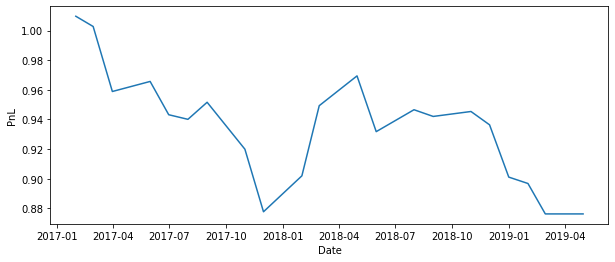

sharpe ratio -0.4770, annual return -0.0248, mdd 0.1335

alpha weighted, industry neutral


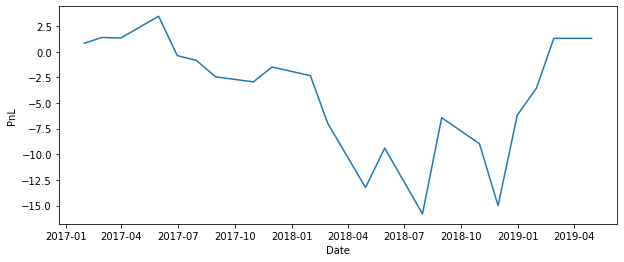

sharpe ratio 0.6099, annual return 0.0532, mdd 19.2914

equal weighted, industry neutral


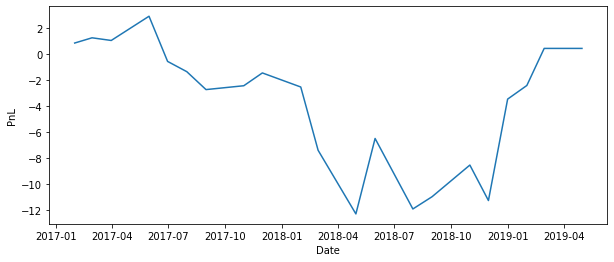

sharpe ratio 0.4708, annual return -0.1486, mdd 15.1667



In [2]:
from integrate_func import *
BNN_Network()

## 7 Conclusion

* Our predictions varied a lot with the initialization, which we probably need to work on more
* Predictions from the Linear model are much more stable, making it more suitable for publications in finance
* The size as well as the non-stationarity of our data does not warrant the ideal use case for Neural Networks

## 8 Future Steps

* Introducing structure in terms of modeling non-stationarity
* Use Frequentist models as a benchmark to compare the Bayesian counterparts with